# CSII 2023 Exercise 03: State Feedback with Dynamic Compensator for Duckiebot Steering

> Blocco con rientro



Reference:
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## State Feedback for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$.

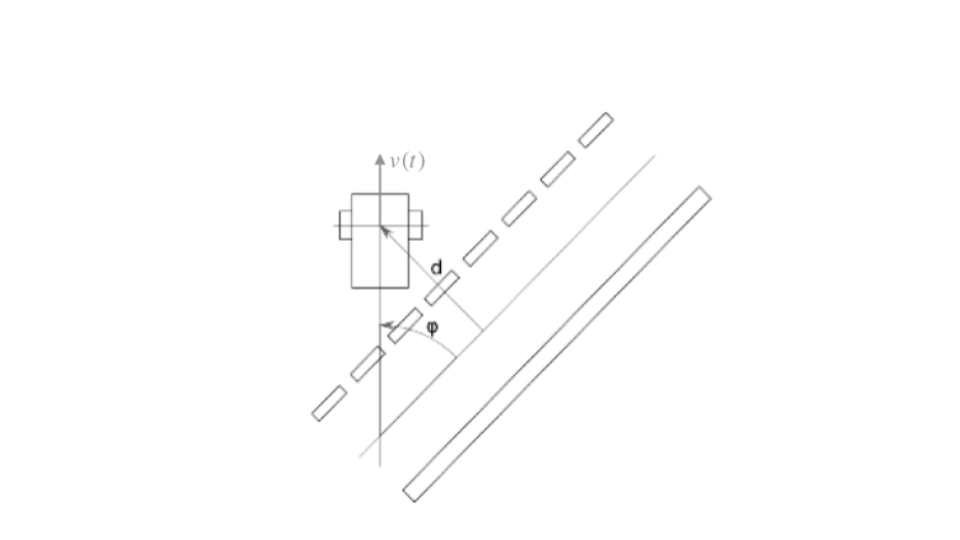

-------
## Installation
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search.





In [ ]:
# Install the required python library with pip
!pip install control

------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.



In [ ]:
# Import the required python libraries
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.

In [ ]:
def unicycle_update(t: float, x: np.array, u: np.array, params: dict):
    # Return the derivative of the state
    max_omega = params.get('max_omega', 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v sin(theta)
        omega     # thdot = w
    ])

def unicycle_output(t: float, x: np.array, u: np.array, params: dict):
    return x[0:2]

## Plotting
The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [ ]:
#@title
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: np.array,
               w_curvy: np.array,
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])
    # Plot the resulting trajectory (and some road boundaries)
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, 'r', linewidth=1)
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)



    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)
    if y_ctr is not None:
        plt.plot(t_curvy, y_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t_curvy, w_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()


def plot_track_multiple_controller(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: List[np.array],
               w_curvy: np.array,
               y_ctr: List[np.array],
               w_ctr: Optional[np.array]) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    number_ctr = len(t)
    plt.figure(figsize=[14, 6])
    # Plot the resulting trajectory (and some road boundaries)

    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(y_ctr[i], x_coord_ref, linewidth=1)
        legend_list.append(f'controller_{i}')

    plt.legend(legend_list, loc='upper left')
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)



    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t[0], y_coord_ref)
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(t[i], y_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t[0], w_curvy)
    for i in range(number_ctr):
        plt.plot(t[i], w_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()

# Utility function to plot the step response
def plot_step_response(t: np.array, y: np.array, u: np.array):
    axes_out = plt.subplot(2, 1, 1)
    plt.sca(axes_out)
    plt.plot(t, y)
    plt.ylabel('Lateral position $y$ in [m]')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')

    axes_input = plt.subplot(2, 1, 2)
    plt.sca(axes_input)
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\omega$ [rad/s]')
    plt.plot(t, u[0])

def plot_sim_results(y_ref: np.array, y: np.array,
                     theta_ref: np.array, theta: np.array,
                     t: np.array, w_ref: np.array,
                     w: np.array) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[15, 4.5])

    # Plot the actual and estimated states
    ax = plt.subplot(1, 2, 1)
    plt.plot(t, y)
    plt.plot(t, y_ref, 'k-.')
    ax.set(xlim=[0, 30])
    plt.legend(['state feedback', 'y', 'reference'])
    plt.xlabel('Time t [sec]')
    plt.ylabel('Lateral position $y$ [m]')

    ax = plt.subplot(2, 2, 2)
    plt.plot(t, theta)
    # plt.plot(t, x[3])
    plt.plot(t, theta_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.ylabel('Angle $\\theta$ [rad]')

    ax = plt.subplot(2, 2, 4)
    plt.plot(t, w)
    # plt.plot(t, u_ofb[0])
    plt.plot(t, w_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\\omega$ [rad/s]')

## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library.

In [ ]:
# Default Duckiebot velocity in m/s
duckie_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the Duckiebot's steering dynamics as an input/output system
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name='duckiebot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=duckie_params)

v0 = duckie_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

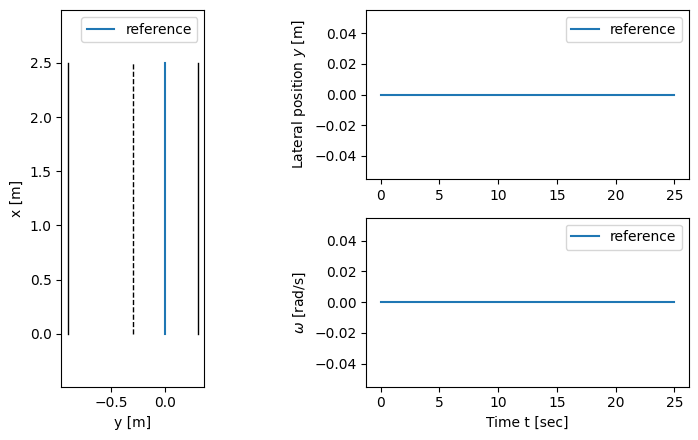

In [ ]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straignt']
curve_difficulty = curve_difficulty_levels[2]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [ ]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C

Linearized system dynamics:

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



-----------------

## Pole Placement

This is the pole placement function from last exercise. This time we only use the `control` library.

In [ ]:
def feedforward_kr_solution(A: np.array, B: np.array, C: np.array, K: np.array) -> np.array:
    ABK = A - B @ K
    ABK_inv = np.linalg.inv(ABK)
    den = C @ ABK_inv @ B
    kr = - 1/den

    return kr

def place_poles_Ackermann(A: np.array, B: np.array, C: np.array,
                          D: float, poles: List, version: str = 'control'):
    K = ct.acker(A,B,poles)
    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, C, D)

    kr = feedforward_kr_solution(A, B, C, K)

    # Scale the input by the feedforward gain
    clsys *= kr

    # Return gains and closed loop system dynamics
    return K, kr, clsys

## Noise

In this section we will do the same as in the last coding exercise, but this time with noise. Choose the noise type which you would like to test in `index_noise`, where you change the integer number to the noise index you want test. Index `index_noise = 0` corresponds to a constant noise (i.e. constant shift of the states), index `index_noise = 1` is a random uniform noise, `index_noise = 2` is white noise and `index_noise = 3` no noise.

In [ ]:
noise_type = ['const', 'uniform', 'white_noise', 'no_noise']
index_noise = 2
noise = noise_type[index_noise]
if noise == 'const':
    n = np.ones(r.shape)*0.5
elif noise=='uniform':
    n = np.random.uniform(low=-0.1, high=0.1, size=r.shape)
elif noise=='white_noise':
    Rw_lat = np.diag([0.001])
    n = ct.white_noise(t, Rw_lat)
else:
    n = np.zeros(r.shape)
U = np.concatenate((r, n))

In the next cell we code the whole state feedback control loop as an input
output system. Take a look and try to understand the code.

In [ ]:
def state_noise(u: np.array) -> np.array:
    y = u[2] + u[1]
    theta = u[3] + u[1]
    return np.array([u[0], y, theta])

def state_feedback_controller(r: np.array, K: np.array, kr: np.array) -> np.array:
    u = -K @ r[1:] + kr * r[0]
    return u

def plant(x: np.array, u: np.array, A: np.array, B: np.array) -> np.array:
    xdot = A @ x + B @ u
    return xdot

def plant_out(x: np.array, u: np.array) -> np.array:
    y = x
    return y

def get_closed_loop_io_system(io_system_params: dict) -> ct.NonlinearIOSystem:
  sys_n = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_noise(u),
      inputs=('r', 'n', 'y', 'theta'),
      outputs=('r', 'yn', 'thetan'),
      params=None,
      name='noise')



  sys_cont = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_feedback_controller(u, params['K'],
                                                        params['kr']),
      inputs=('reference','x1', 'x2'),
      outputs=('control'),
      params=io_system_params,
      name='controller')

  sys_dyn = ct.NonlinearIOSystem(
      lambda t, x, u, params: plant(x, u, params['A'], params['B']),
      lambda t, x, u, params: plant_out(x, u),
      inputs=('control',),
      outputs=('y', 'theta'),
      states=('x1', 'x2'),
      params=io_system_params,
      name='plant')


  io_closed = ct.interconnect(
    [sys_dyn, sys_cont, sys_n],       # systems
    connections=[
      ['plant.control', 'controller.control'],
      ['controller.x1', 'noise.yn'],
      ['controller.x2', 'noise.thetan'],
      ['controller.reference', 'noise.r'],
      ['noise.theta', 'plant.theta'],
      ['noise.y', 'plant.y']
    ],
    inplist=['noise.r', 'noise.n'],
    outlist=['plant.y', 'controller.control']
  )

  return io_closed

In [ ]:
def simulate_noisy(A: np.array, B: np.array, C: np.array,
                   t: np.array, U: np.array, X0: List,
                   poles: List) -> Tuple[np.array, np.array]:
                   K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0,
                                    poles=poles, version='control')
                   io_system_params = {'A': A, 'B': B, 'C': C, 'D': 0, 'K': K, 'kr': kr}
                   io_closed = get_closed_loop_io_system(io_system_params)
                   tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)

                   return tp, yp

In the next cell you can choose your poles in `poles` and initial state `x0` and simulate the system.

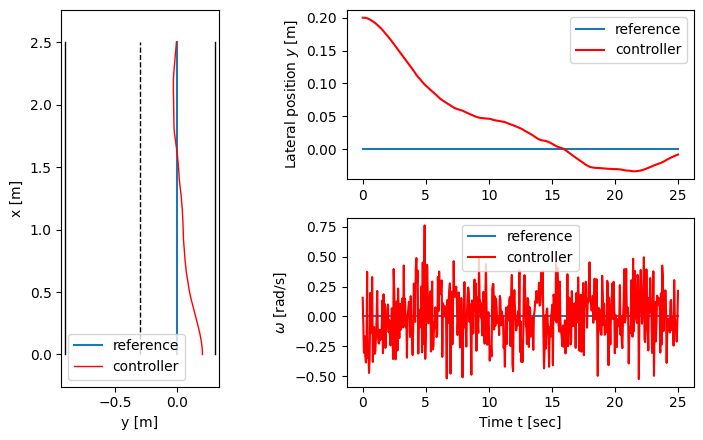

In [ ]:
poles = [-0.3, -0.3]
x0 = [0.2, 0]

tp, yp = simulate_noisy(A, B, C, t, U, x0, poles)
plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy,
            yp[0], yp[1])

## Exercise 1: Dynamic Compensator
Now, we would like to add a dynamic compensator as learned in the lecture. Write a function `get_dynamic_compensator_system_exercise` which takes the system matrices as inputs and a list of poles and transforms the system to a new system with an augmented state. Moreover, calculate the feedback gain and the feedforward gain and store all matrices in a dictionary.


In [ ]:
def get_dynamic_compensator_system_exercise(A: np.array, B: np.array, C: np.array, p: List) -> dict:
  #TODO
  A_dc = np.zeros((3,3))
  B_dc = np.zeros((3,1))
  C_dc = np.zeros((1,3))
  K_dc = np.zeros((1,3))
  kr_dc = 0
  io_system_params = {'A': A_dc, 'B': B_dc, 'C': C_dc,
                      'D': 0, 'K': K_dc, 'kr': kr_dc}

  return io_system_params

## Solution Exercise 1: Dynamic Compensator

In [ ]:
#@title
def get_dynamic_compensator_system(A: np.array, B: np.array, C: np.array, p: List) -> dict:
  A_dc = np.concatenate((A, np.array([[1, 0]])), axis=0)
  A_dc = np.concatenate((A_dc, np.array([[0], [0], [0]])), axis=1)
  B_dc = np.concatenate((B, np.array([[0]])), axis=0)
  C_dc = np.concatenate((C, np.array([[0]])), axis=1)
  K_dc = ct.acker(A_dc,B_dc,p)
  kr_dc = feedforward_kr_solution(A, B, C, K_dc[:,:2])

  io_system_params = {'A': A_dc, 'B': B_dc, 'C': C_dc,
                      'D': 0, 'K': K_dc, 'kr': kr_dc}

  return io_system_params

Test your implementation here:

In [ ]:
io_test_ex = get_dynamic_compensator_system_exercise(A, B, C, [-1, -1, -1])
io_test_sol = get_dynamic_compensator_system(A, B, C, [-1, -1, -1])

print(f'Your implementation: {io_test_ex}')
print(f'Solution: {io_test_sol}')

Your implementation: {'A': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 'B': array([[0.],
       [0.],
       [0.]]), 'C': array([[0., 0., 0.]]), 'D': 0, 'K': array([[0., 0., 0.]]), 'kr': 0}
Solution: {'A': array([[0. , 0.1, 0. ],
       [0. , 0. , 0. ],
       [1. , 0. , 0. ]]), 'B': array([[0.],
       [1.],
       [0.]]), 'C': array([[1., 0., 0.]]), 'D': 0, 'K': array([[30.,  3., 10.]]), 'kr': array([[30.]])}


## Exercise 2: Dynamic Compensator Control
Write the function `state_feedback_controller_dc_exercise`, which calculates the control input `u`. The array `r` contains the states and the reference. The first element of `r` is the reference and the rest are the states

In [ ]:
def state_feedback_controller_dc_exercise(r: np.array, K: np.array, kr: np.array) -> np.array:
    # TODO
    return np.array([0, 0])

## Solution Exercise 2: Dynamic Compensator Control

In [ ]:
#@title
def state_feedback_controller_dc(r: np.array, K: np.array, kr: np.array) -> np.array:
    u = -K @ r[1:] + kr * r[0]
    return np.array([r[0], u])

Test your implementation here:

In [ ]:
r_test = np.array([1, 1, 1, 1])
K_test = np.array([1, 1, 1])
kr_test =  1

u_test_ex = state_feedback_controller_dc_exercise(r_test, K_test, kr_test)
u_test_sol = state_feedback_controller_dc(r_test, K_test, kr_test)

print(f'Your implementation: {u_test_ex}')
print(f'Solution: {u_test_sol}')

Your implementation: [0 0]
Solution: [ 1 -2]


## Exercise 3: Dynamic Compensator System Dynamics
Write the function `plant_dc_exercise`, which calculates the derivative of each state. The array `u` contains again the reference and the states, where the first element is the reference.


In [ ]:
def plant_dc_exercise(x: np.array, u: np.array, A: np.array, B: np.array) -> np.array:
    # TODO
    return np.array([0, 0, 0])

## Solution Exercise 3: Dynamic Compensator System Dynamics

In [ ]:
#@title
def plant_dc(x: np.array, u: np.array, A: np.array, B: np.array) -> np.array:
    a = A @ x
    b = B @ u[1:]
    c = np.array([0, 0, -u[0]])
    xdot = a + b + c
    return xdot

Test your code here:

In [ ]:
x_test = np.array([1, 1, 1])
u_test = np.array([1, 1])

A_test = np.array([[0, 1, 0], [0, 0, 0], [1, 0, 0]])
B_test = np.array([[0], [1], [0]])

xdot_test_ex = plant_dc_exercise(x_test, u_test, A_test, B_test)
xdot_test_sol = plant_dc(x_test, u_test, A_test, B_test)

print(f'Your implementation: {xdot_test_ex}')
print(f'Solution: {xdot_test_sol}')

Your implementation: [0 0 0]
Solution: [1 1 0]


## Dynamic Compensator
Now we are going to simulate the dynamic compensator. Check the implementation to see how we build the state feedback controller.

In [ ]:
def state_noise_dc(u: np.array) -> np.array:
    y = u[2] + u[1]
    theta = u[3] + u[1]
    z = u[4]
    return np.array([u[0], y, theta, z])

def state_feedback_controller_dc(r: np.array, K: np.array, kr: np.array) -> np.array:
    u = -K @ r[1:] + kr * r[0]
    return np.array([r[0], u])

def plant_dc(x: np.array, u: np.array, A: np.array, B: np.array) -> np.array:
    a = A @ x
    b = B @ u[1:]
    c = np.array([0, 0, -u[0]])
    xdot = a + b + c
    return xdot

def plant_out_dc(x: np.array, u: np.array) -> np.array:
    y = x
    return y

def get_closed_loop_dc_io_system(io_system_params: dict, solution: bool = True) -> ct.NonlinearIOSystem:
  sys_n_dc = ct.NonlinearIOSystem(
    None,
    lambda t, x, u, params: state_noise_dc(u),
    inputs=('r', 'n', 'y', 'theta', 'z'),
    outputs=('r', 'yn', 'thetan', 'zn'),
    params=None,
    name='noise')

  if solution:
    sys_cont_dc = ct.NonlinearIOSystem(
        None,
        lambda t, x, u, params: state_feedback_controller_dc(u, params['K'],
                                                          params['kr']),
        inputs=('reference','x1', 'x2', 'z'),
        outputs=('r', 'control'),
        params=io_system_params,
        name='controller')
  else:
    sys_cont_dc = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_feedback_controller_dc_exercise(u, params['K'],
                                                        params['kr']),
      inputs=('reference','x1', 'x2', 'z'),
      outputs=('r', 'control'),
      params=io_system_params,
      name='controller')

  if solution:
    sys_dyn_dc = ct.NonlinearIOSystem(
        lambda t, x, u, params: plant_dc(x, u, params['A'], params['B']),
        lambda t, x, u, params: plant_out_dc(x, u),
        inputs=('r', 'control'),
        outputs=('y', 'theta', 'z'),
        states=('x1', 'x2', 'x3'),
        params=io_system_params,
        name='plant')
  else:
    sys_dyn_dc = ct.NonlinearIOSystem(
        lambda t, x, u, params: plant_dc_exercise(x, u, params['A'], params['B']),
        lambda t, x, u, params: plant_out_dc(x, u),
        inputs=('r', 'control'),
        outputs=('y', 'theta', 'z'),
        states=('x1', 'x2', 'x3'),
        params=io_system_params,
        name='plant')

  io_closed_dc = ct.interconnect(
    [sys_dyn_dc, sys_cont_dc, sys_n_dc],       # systems
    connections=[
      ['plant.control', 'controller.control'],
      ['plant.r', 'controller.r'],
      ['controller.x1', 'noise.yn'],
      ['controller.x2', 'noise.thetan'],
      ['controller.reference', 'noise.r'],
      ['controller.z', 'noise.zn'],
      ['noise.theta', 'plant.theta'],
      ['noise.y', 'plant.y'],
      ['noise.z', 'plant.z']
    ],
    inplist=['noise.r', 'noise.n'],
    outlist=['plant.y', 'controller.control'])

  return io_closed_dc

In [ ]:
def simulate_noisy_dc(A: np.array, B: np.array, C: np.array,
                   t: np.array, U: np.array, X0: List,
                   poles: List, solution: bool=True) -> Tuple[np.array, np.array]:

                   if solution:
                      io_system_params_dc = get_dynamic_compensator_system(A, B, C, poles)
                      io_closed = get_closed_loop_dc_io_system(io_system_params_dc)
                   else:
                      io_system_params_dc = get_dynamic_compensator_system_exercise(A, B, C, poles)
                      io_closed = get_closed_loop_dc_io_system(io_system_params_dc, solution)
                   tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)

                   return tp, yp

Now we are going to compare the dynamic compensator against the standard implemenation without a dynamic compensator. Add the poles for the dynamic compensator in `poles_dc` and for the standard state feedback in `poles`. If you want to test your own implementations from the exercises, set `solution = False`. If you set the last pole of `poles_dc` to `-0.00001`, the both system will become almost identical.

<ipython-input-27-819d3e25655e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([r[0], u])


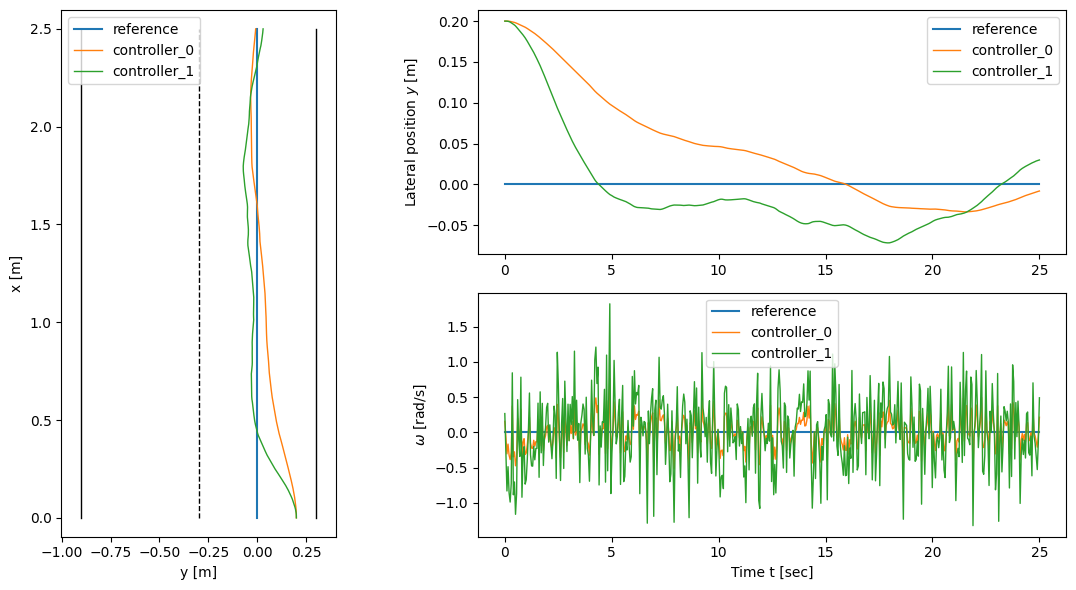

In [ ]:
solution = True
poles_dc = [-0.3, -0.3, -0.3]
poles = [-0.3, -0.3]
x0_dc = [0.2, 0, 0]
x0 = [0.2, 0]

tp, yp = simulate_noisy(A, B, C, t, U, x0, poles)
tp_dc, yp_dc = simulate_noisy_dc(A, B, C, t, U, x0_dc, poles_dc, solution)

t_list = [tp, tp_dc]
y_list = [yp[0], yp_dc[0]]
u_list = [yp[1], yp_dc[1]]
plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)

## Poles Comparison with Noise

In this section we will do the same as before, just comparing different poles against each other. We will compare aggressive poles, less aggressive poles and complex conjugate poles.

<ipython-input-27-819d3e25655e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([r[0], u])


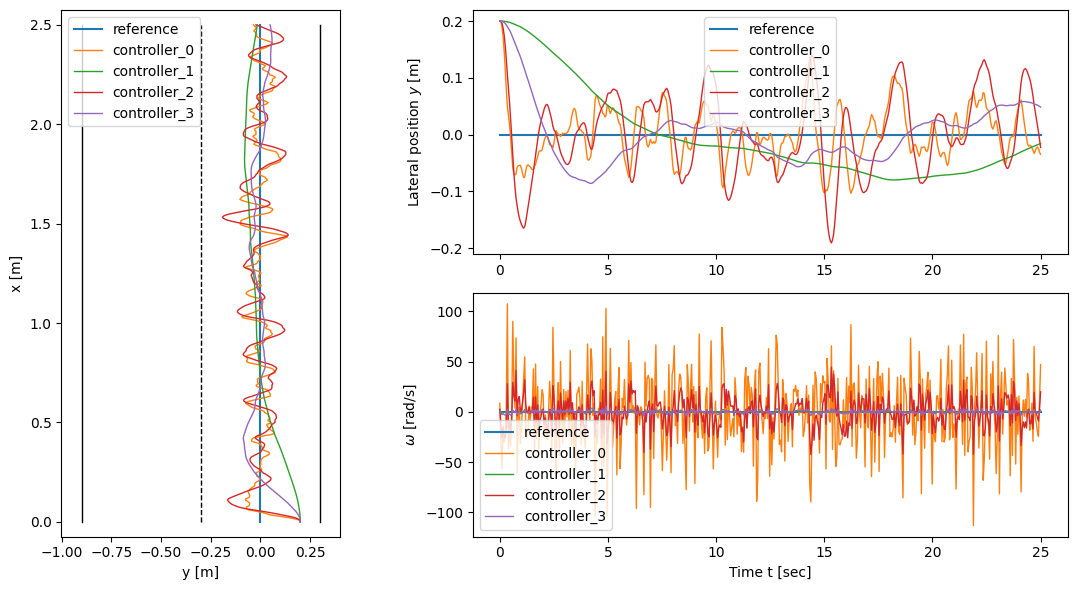

In [ ]:
poles_aggressive = [-3, -3, -3]
poles_easy = [-0.2, -0.2, -0.2]
poles_complex_1 = [-0.5+3j, -0.5-3j, -0.2]
poles_complex_2 = [-0.5+0.5j, -0.5-0.5j, -0.5]
x0_dc = [0.2, 0, 0]

pole_list = [poles_aggressive, poles_easy, poles_complex_1, poles_complex_2]
t_list = []
y_list = []
u_list = []
for p in pole_list:
  tp_dc, yp_dc = simulate_noisy_dc(A, B, C, t, U, x0_dc, p)
  t_list.append(tp_dc)
  y_list.append(yp_dc[0])
  u_list.append(yp_dc[1])

plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)


## Outlook
- Change the tracks and create your own reference track
- Use different poles and check how the controller performance changes
- Change the the noise type
- Change the initial conditions `x0`, `x0_dc`
- Ask ChatGPT for solutions and compare them with your own :)